In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df1 = pd.read_csv(r'F:\DS\Time_Series_Analysis\[ FreeCourseWeb.com ] Udemy - Python for Time Series Data Analysis\01. Introduction\UDEMY_TSA_FINAL\Data\DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

df2 = pd.read_csv(r'F:\DS\Time_Series_Analysis\[ FreeCourseWeb.com ] Udemy - Python for Time Series Data Analysis\01. Introduction\UDEMY_TSA_FINAL\Data\TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

# Automate_augmented_Dickey_Fuller_Test

In [2]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

# ARMA_(p,q)

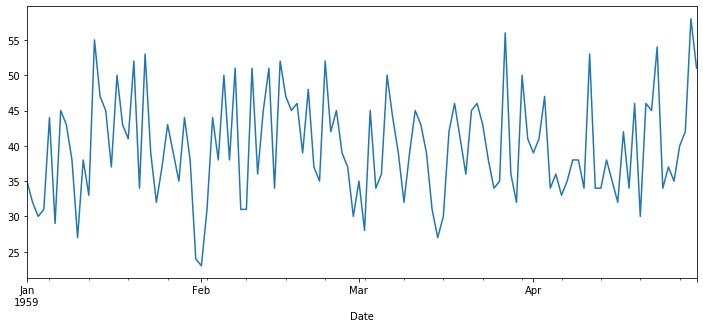

In [3]:
df1['Births'].plot(figsize=(12,5));

In [4]:
adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


## Determine the (p,q) ARMA Orders using pmdarima.auto_arima

In [5]:
auto_arima(df1['Births'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Sat, 01 Feb 2020   AIC                            823.489
Time:                        18:37:29   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (Q):                       44.41   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.29   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Split_the_Data_Train_and_Test

In [6]:
# Set one month for testing
train = df1.iloc[:90]
test = df1.iloc[90:]

### Fit an ARMA(p,q) Model

In [7]:
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Sat, 01 Feb 2020   AIC                            627.809
Time:                        18:38:47   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

### Obtain a month's worth of predicted values

In [8]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

### Plot predictions against known values

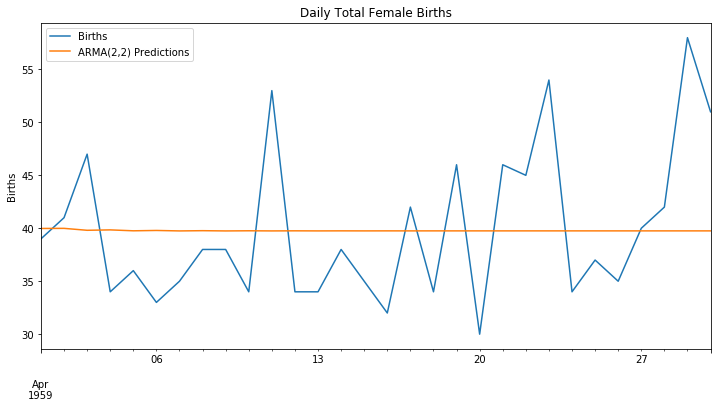

In [9]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# ARIMA_MODEL_(p,d,q)

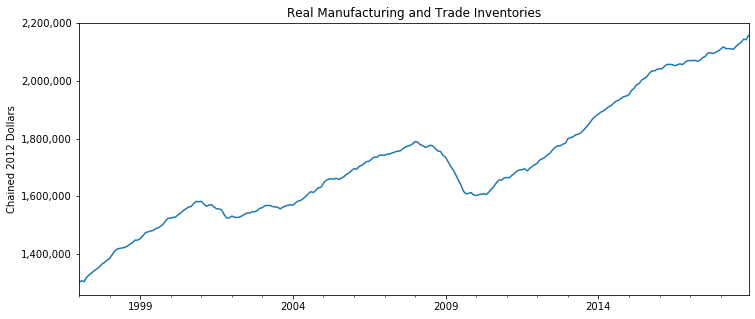

In [10]:
# HERE'S A TRICK TO ADD COMMAS TO Y-AXIS TICK VALUES
import matplotlib.ticker as ticker
formatter = ticker.StrMethodFormatter('{x:,.0f}')

title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## Run an ETS Decomposition (optional)

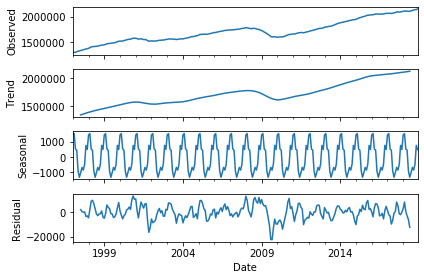

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df2['Inventories'], model='additive')  # model='add' also works
result.plot();

### Use pmdarima.auto_arima to determine ARIMA Orders

In [12]:
auto_arima(df2['Inventories'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 01 Feb 2020   AIC                           5348.037
Time:                        18:42:17   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Run the augmented Dickey-Fuller Test on the First Difference

In [13]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['Inventories'],k_diff=1)

# Equivalent to:
# df1['d1'] = df1['Inventories'] - df1['Inventories'].shift(1)

adf_test(df2['d1'],'Real Manufacturing and Trade Inventories')

Augmented Dickey-Fuller Test: Real Manufacturing and Trade Inventories
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### Run the ACF and PACF plots

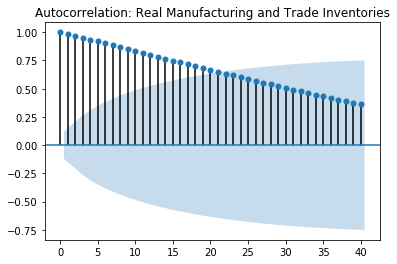

In [14]:
title = 'Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_acf(df2['Inventories'],title=title,lags=lags);

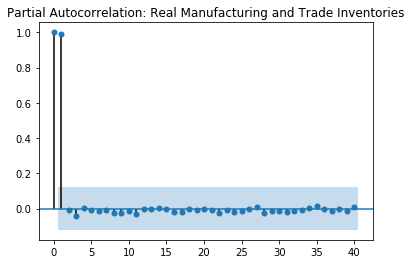

In [15]:
title = 'Partial Autocorrelation: Real Manufacturing and Trade Inventories'
lags = 40
plot_pacf(df2['Inventories'],title=title,lags=lags);

## Auto_ARIMA_pmdarima

In [16]:
stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=5348.037, BIC=5355.181, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=5399.843, BIC=5410.560, Fit time=0.300 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=5350.241, BIC=5360.957, Fit time=0.132 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=5409.217, BIC=5412.789, Fit time=0.030 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=5378.835, BIC=5393.124, Fit time=0.693 seconds
Total fit time: 1.225 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2672.018
Date:                Sat, 01 Feb 2020   AIC                           5348.037
Time:                        18:43:58   BIC                           5355.181
Sample:                             0   HQIC                          5350.908
                                - 264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3258.3802    470.991      6.918      0.000    2335.255    4181.506
sigma2       3.91e+07   2.95e+06     13.250      0.000    3.33e+07    4.49e+07
===================================================================================
Ljung-Box (Q):                      455.75   Jarque-Bera (JB):               100.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                            -1.15
Prob(H) (two-sided):                  0.48   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
len(df2)

264

### Split_The_Data

In [18]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

### Fit an ARIMA(1,1,1) Model

In [19]:
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.397
Method:                       css-mle   S.D. of innovations           4845.058
Date:                Sat, 01 Feb 2020   AIC                           4980.793
Time:                        18:45:11   BIC                           4994.895
Sample:                    02-01-1997   HQIC                          4986.468
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3165.3815   1345.220      2.353      0.019     528.799    5801.964
ar.L1.D.Inventories     0.9026      0.039     23.008      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7919           +0.0000j            1.7919            0.0000
-----------------------------------------------------------------------------
"""

In [20]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [21]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Inventories'][i]}")

predicted=2107141.253, expected=2110158
predicted=2110509.594, expected=2118199
predicted=2113858.159, expected=2112427
predicted=2117188.875, expected=2112276
predicted=2120503.481, expected=2111835
predicted=2123803.547, expected=2109298
predicted=2127090.489, expected=2119618
predicted=2130365.586, expected=2127170
predicted=2133629.992, expected=2134172
predicted=2136884.75 , expected=2144639
predicted=2140130.799, expected=2143001
predicted=2143368.988, expected=2158115


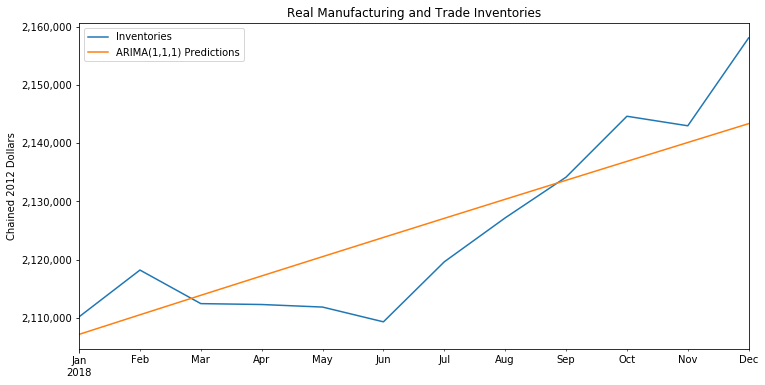

In [22]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);

## Evaluate_The_Model

In [23]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) MSE Error: {error:11.10}')

ARIMA(1,1,1) MSE Error: 61010056.19


In [24]:
from statsmodels.tools.eval_measures import rmse

error = rmse(test['Inventories'], predictions)
print(f'ARIMA(1,1,1) RMSE Error: {error:11.10}')

ARIMA(1,1,1) RMSE Error: 7810.893431


### Retrain the model on the full data, and forecast the future

In [25]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

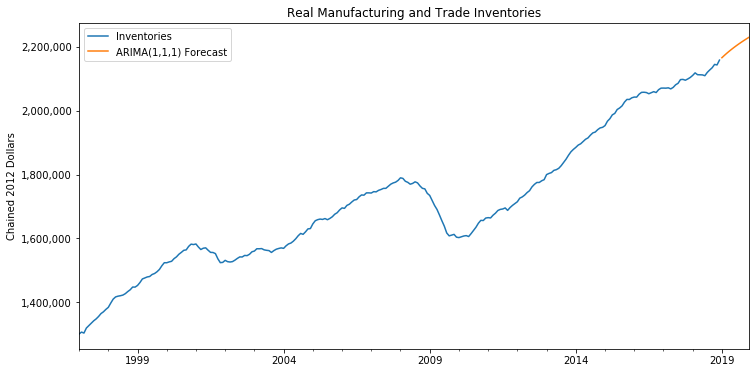

In [26]:
# Plot predictions against known values
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter);